# How much green is Delhi as on 15 Oct 2017?

 <h1>Table of Contents<span class="tocSkip"></span></h1>

<div class="toc">
    <ul class="toc-item">
        <li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
        <li><span><a href="#Necessary-Imports" data-toc-modified-id="Necessary-Imports-1">Necessary Imports</a></span></li>
        <li><span><a href="#Connect-to-your-GIS" data-toc-modified-id="Connect-to-your-GIS-2">Connect to your GIS</a></span></li>
        <li><span><a href="#Get-the-data-for-analysis" data-toc-modified-id="Get-the-data-for-analysis-3">Get the data for analysis</a></span></li>
        <li><span><a href="#Filter-imageries-based-on-cloud-cover-and-Acquisition-Date" data-toc-modified-id="Filter-imageries-based-on-cloud-cover-and-Acquisition-Date-5">Filter imageries based on cloud cover and Acquisition Date</a></span></li>
        <li><span><a href="#Creating-NDVI-composite-for-the-filtered-imagery" data-toc-modified-id="Creating-NDVI-composite-for-the-filtered-imagery-6">Creating NDVI composite for the filtered imagery</a></span></li>
        <li><span><a href="#Masking-NDVI-composite-for-green-area-calculation" data-toc-modified-id="Masking-NDVI-composite-for-green-area-calculation-7">Masking NDVI composite for green area calculation</a></span></li>
        <li><span><a href="#Visualising-results-on-map" data-toc-modified-id="Visualising-results-on-map-8">Visualising results on map</a></span></li>
        <li><span><a href="#Area-Derivation" data-toc-modified-id="Area-Derivation-9">Area Derivation</a></span></li>
        <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10">Conclusion</a></span></li>
        <li><span><a href="#References" data-toc-modified-id="References-11">References</a></span></li>
    </ul>
</div>

# Introduction

The India State of Forests Report (ISFR) 2017, showed that the green cover of Delhi has increased from 20.08% in 2015 to 20.22% in 2017, as observed from satellite imageries of Delhi for the month of October and November [1]. This was a welcome news for the city struggling with severe pollution and rising population, which makes it necessary to monitor the city's green cover and keep the city liveable. 

This sample shows the capabilities of spectral indices such as Normalized Difference Vegetation index (NDVI) for the calculation of green cover in Delhi, India on 15 October 2017 using Landsat 8 imagery.

# Necessary Imports

In [13]:
%matplotlib inline

import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geocoding import geocode

# Connect to your GIS

In [2]:
gis = GIS("your_enterprise_profile")

# Get the data for analysis

Search for Multispectral Landsat layer in ArcGIS Online.

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
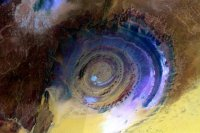

In [3]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

Search for <b>India State Boundaries 2018</b> layer in ArcGIS Online. This layer has all the state boundaries for India. The boundary of Delhi can be filtered from the layer, as this notebook focuses on the city's green cover.

In [4]:
boundaries = gis.content.search('India State Boundaries 2018', 'Feature Layer', outside_org=True)[0]
state_boundaries = boundaries.layers[1]

Extracting Landsat imagery for New Delhi Region

In [5]:
area = geocode("New Delhi, India", out_sr=landsat.properties.spatialReference)[0]
landsat.extent = area['extent']

In State Boundary layer, OBJECTID for Delhi is 7 which is used below. Also, it is important to add extent to the geometry of selected boundary.

In [6]:
delhi = state_boundaries.query(where='OBJECTID=7')
delhi_geom = delhi.features[0].geometry
delhi_geom['spatialReference'] = {'wkid':4326}
delhi.features[0].extent = area['extent']

# Filter imageries based on cloud cover and Acquisition Date

In order to have good result, it is important to select cloud free imagery from the image collection for a specified time duration. In this example we have selected all the imageries captured between 1 October, 2017 to 31 December, 2017 with cloud cover less than or equal to 5% for Delhi.

In [7]:
selected = landsat.filter_by(where="(Category = 1) AND (cloudcover <=0.05)",
                             time=[datetime.datetime(2017, 10, 1), datetime.datetime(2017, 12, 31)],
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear", 
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,Shape_Length,Shape_Area,SHAPE
0,2096408,2017-10-06 05:25:18,LC81470402017279LGN00_MTL,0.0000,279,852147.705738,4.534369e+10,"{'rings': [[[8625624.2331, 3442812.7971], [857..."
1,2095521,2017-10-15 05:19:09,LC81460402017288LGN00_MTL,0.0011,288,852002.482986,4.532785e+10,"{'rings': [[[8796766.063900001, 3442853.641099..."
2,2095533,2017-10-15 05:19:32,LC81460412017288LGN00_MTL,0.0001,288,840538.454365,4.411500e+10,"{'rings': [[[8754232.399300002, 3260266.637200..."
3,2095534,2017-10-31 05:19:33,LC81460412017304LGN00_MTL,0.0335,304,840790.091989,4.414146e+10,"{'rings': [[[8754361.912, 3260262.332699999], ..."
4,2203649,2017-11-23 05:25:14,LC81470402017327LGN00_MTL,0.0333,327,852242.226027,4.535328e+10,"{'rings': [[[8627133.4597, 3442780.260499999],..."
5,2206118,2017-12-02 05:19:00,LC81460402017336LGN00_MTL,0.0015,336,851555.400431,4.528033e+10,"{'rings': [[[8800038.6758, 3442628.6884000003]..."
6,2211732,2017-12-09 05:25:11,LC81470402017343LGN00_MTL,0.0099,343,852179.154208,4.532813e+10,"{'rings': [[[8626952.113400001, 3442914.852600..."
7,2214288,2017-12-18 05:19:26,LC81460412017352LGN00_MTL,0.0030,352,840946.176659,4.415843e+10,"{'rings': [[[8754656.32, 3260315.098700002], [..."


Selecting imagery dated 15 October, 2017 from the collection using its <i>OBJECTID<i>.

In [8]:
delhi_image = landsat.filter_by('OBJECTID=2095521') # 2017-10-15 

Applying Natural color to verify the quality of image

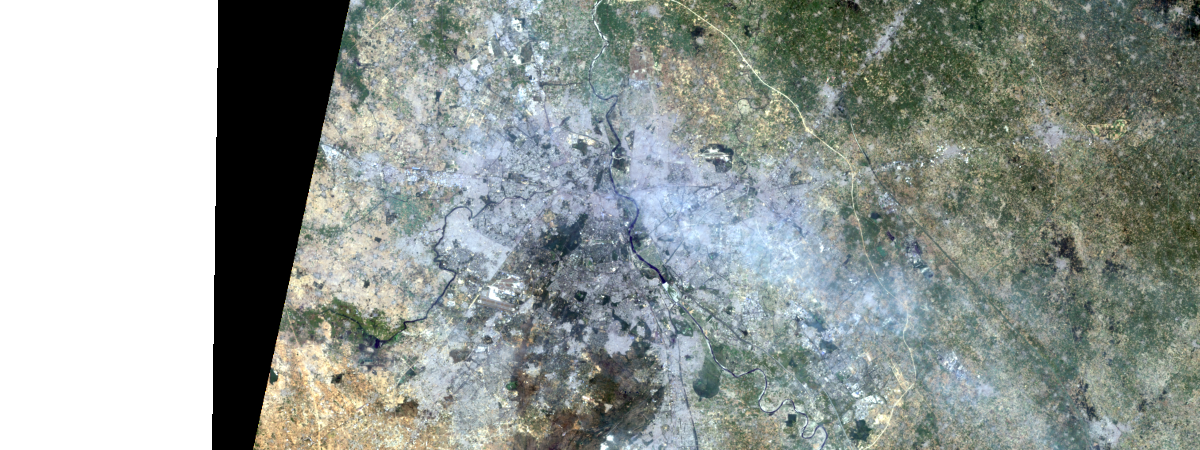

In [9]:
apply(delhi_image, 'Natural Color with DRA')

# Creating NDVI composite for the filtered imagery

In the Landsat layer properties, pre defined "NDVI Raw" function is applied to get the NDVI composite.

In [10]:
ndvi_colorized = apply(delhi_image, 'NDVI Raw')

Clipping the NDVI composite for Delhi and setting the extent of the generated raster.

In [11]:
delhi_clip = clip(ndvi_colorized, delhi_geom)
delhi_clip.extent = area['extent']

# Masking NDVI composite for green area calculation

"remap" function is used to define the NDVI range for agricultural land and forest. The NDVI values between 0.4 - 0.5 represents agricultural land whereas NDVI values between 0.5 - 1 shows forest/ tree cover [2].

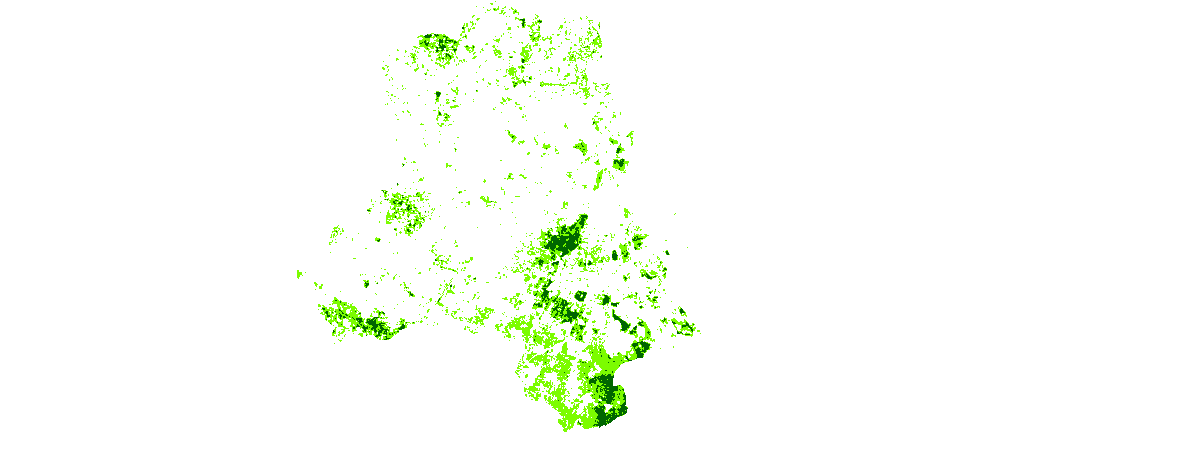

In [14]:
threshold_val = 0.5
masked = colormap(remap(delhi_clip, 
                        input_ranges=[0.4,threshold_val,     # agricultural land
                                     threshold_val, 1],      # forest area/ tree cover
                        output_values=[1, 2]),
                        colormap=[[1, 124, 252, 0], [2, 0, 102, 0]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

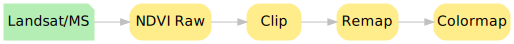

In [15]:
masked.draw_graph()

# Visualising results on map

In [16]:
m = gis.map('New Delhi, India')
m.add_layer(masked)
m.legend = True

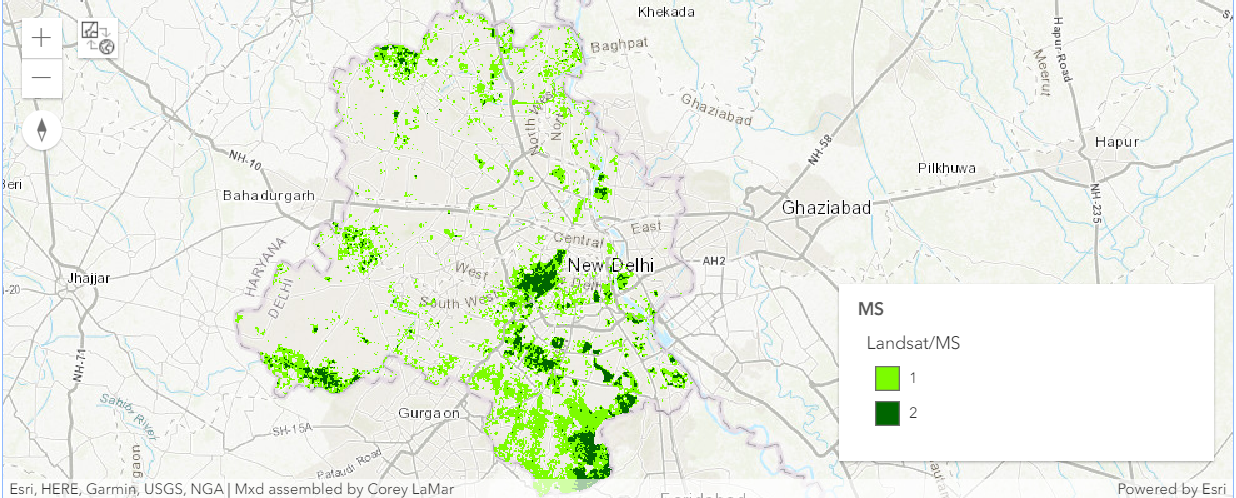

Here, the pixels with light green color having a value of "1" shown in the map legend represent agricultural land whereas the pixels with dark green color having a value of "2" represent forest area/ tree cover.

# Area Derivation

Now we will calculate the total green cover of Delhi. It is important to note that pixels belonging to agricultural land as well as forest area/ tree cover are considered as green cover in the calculation.

In [17]:
pixx = (delhi_clip.extent['xmax'] - delhi_clip.extent['xmin']) / 1200
pixy = (delhi_clip.extent['ymax'] - delhi_clip.extent['ymin']) / 450

res = masked.compute_histograms(delhi_clip.extent,
                               pixel_size={'x':pixx, 'y':pixy})
numpix = 0
histogram = res['histograms'][0]['counts'][0:]
for i in histogram[1:]:
    numpix += i

In [18]:
sqmarea = numpix * pixx * pixy # in sq. m
acres = 0.00024711 * sqmarea   # in acres
HTML('<h3>Total Green cover in Delhi is ~ <i>{}%</i> of the total \
     geographical area of Delhi.</h3>'.format(int((acres/419004.17)*100)))

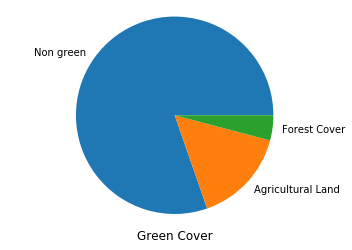

In [21]:
plt.title('Green Cover', y=-0.1)
plt.pie(histogram, labels=['Non green','Agricultural Land', 'Forest Cover']);
plt.axis('equal');

The pie chart clearly shows the distribution of agricultural land, forest cover and non green areas like urban areas, water, etc. Here, the non green areas contribute around 81% of Delhi's land and remaining 19% goes with forest cover and agricultural land. 

# Conclusion

In this study, green cover of Delhi is calculated using Landsat 8 imagery for 15 October, 2017. Normalised Difference Vegetation Index (NDVI) is used for the calculation of green areas, which is a well known and widely accepted spectral index for vegetation studies.

NDVI is used here compared to the other spectral indices because it is easy to compute and requires only two bands. Pixels with NDVI values greater than 0.4 and less than 0.5 are considered as agricultural land, parks, etc and the pixels with more than or equal to 0.5 NDVI values are considered as tree cover/ forest areas.

Finally, the area of the pixels of agricultural land and forest class is calculated to estimate overall green cover of Delhi. Finally, the area of the pixels of agricultural land and forest class is calculated to estimate overall green cover of Delhi.

The study shows how the green land cover of an area could be easily computed in few lines of code using Esri's predefined NDVI layer and Landsat 8 imagery from ArcGIS server. 

# References

[1] https://indianexpress.com/article/cities/delhi/delhis-green-cover-is-on-the-rise-but-its-not-all-good-news-5624341/  
[2] https://earthobservatory.nasa.gov/features/MeasuringVegetation